In [3]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [4]:
runs = 10000 * 4
P = [1,10,100,1000]#np.linspace(1,4,4)
std = np.linspace(0.5,2,100)
msg_len = 4

In [5]:
# Message and Encoding - Trasmission end basically

# Convolutional encoder - based on https://nptel.ac.in/courses/117105077/35
def convEncoder(rec, prev1, prev2):
    out = []
    out.append((rec + prev1 + prev2) % 2)
    out.append((rec + prev2) % 2)
    
    return out

def msgOutput(power, msg_len):
    msg = []
    
    for i in range(msg_len):
        if(np.random.uniform() > 0.5):
            msg.append(1)
        else:
            msg.append(0)
    
    code = []   # each row is a pair of transmited bits - corresponds to 4-QAM location
    prev1 = 0
    prev2 = 0
    for i in range(len(msg)):
        code.append(convEncoder(msg[i], prev1, prev2))
        prev2 = prev1
        prev1 = msg[i]
    
    for i in range(len(msg)):
        for j in range(len(code[0])):
            if(code[i][j] == 1):
                code[i][j] = np.sqrt(power/2)
            else:
                code[i][j] = -np.sqrt(power/2)
    
    return [np.array(msg), np.array(code)]
        


In [6]:
# Some defaults for the Viterbi Decoder

states = ["00", "01", "10", "11"]
trellis = {
    "00" : {"00" : {"msg" : 0, "code" : "00"}, "01" : {"msg" : 0, "code" : "11"}},
    "01" : {"10" : {"msg" : 0, "code" : "10"}, "11" : {"msg" : 0, "code" : "01"}},
    "10" : {"00" : {"msg" : 1, "code" : "11"}, "01" : {"msg" : 1, "code" : "00"}},
    "11" : {"10" : {"msg" : 1, "code" : "01"}, "11" : {"msg" : 1, "code" : "10"}}
}


In [12]:
# Reciever Code - adds in fading and noise

def vitReciever(code, std):
    
    #add noise to each bit
    noise = np.random.normal(0,std,code.shape)
    rec = code + noise
    
    recCode = np.zeros(code.shape)
    for i in range(recCode.shape[0]):
        for j in range(recCode.shape[1]):
            if rec[i][j] > 0:
                recCode[i][j] = 1
#         print("".join(str(int(e)) for e in recCode[i]))
    
    recMsg = []
    for i in range(recCode.shape[0]):
        recMsg.append("".join(str(int(e)) for e in recCode[i]))
    
#     print(recMsg)
    decoded = convDecoder(recMsg)
    
    return decoded


def convDecoder(recMsg, states=states, trellis=trellis):
    V = [{}]
    
    # init first layer to all zeros
    for st in states:
        V[0][st] = {"metric" : 0, "minPrev" : "EOT"}
    
    # build next layers
    for i in range(1, len(recMsg)+1):
        V.append({})
        
        # iterate through each state in the layer
        for st in states:
            curMin = np.inf
            curMinSt = ""
            
            # for all connections to that node find the min metric one
            for prevSt in trellis[st]:
                count = sum(1 for a, b in zip(trellis[st][prevSt]["code"], recMsg[i-1]) if a != b)
                metric = count + V[i-1][prevSt]["metric"]
                if(metric < curMin):
                    curMin = metric
                    curMinSt = prevSt
            
            # save the min metric as that node's metric
            V[i][st] = {"metric" : curMin, "minPrev" : curMinSt}
    
#     print(V)
    # begin backtrace and start storing output
    output = []
    minMet = np.inf
    minSt = ""
    for st in V[-1]:
        if(V[-1][st]["metric"] < minMet):
            minMet = V[-1][st]["metric"]
            minSt = st

    for i in range(len(recMsg), 0, -1):
        past = V[i][minSt]["minPrev"]
        output.append(trellis[minSt][past]["msg"])
        minSt = past

    return output[::-1]

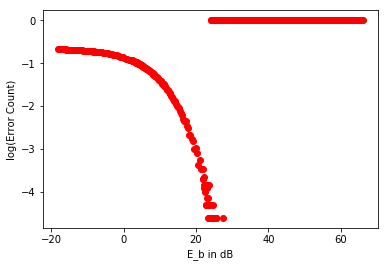

In [11]:
d = 2
E_b = []
errors = []

for test_P in P:
    for test_std in std:
        err = 0
        
        for i in range(int(runs/msg_len)):
            errs = 0
            [msg, code] = msgOutput(test_P, msg_len)
            recMsg = vitReciever(code, test_std)
            errs += sum(1 for a, b in zip("".join(str(int(e)) for e in msg), "".join(str(int(v)) for v in recMsg)) if a != b)
            if(errs > 0):
                err += 1
        if(np.random.uniform() > 0.999):
            print(err, test_P)
        E_b.append(test_P/(d*test_std**2))
        errors.append(4*err/(runs*d**2))
        
        if E_b[-1] == 0:
            E_b[-1] = 10**0
        if errors[-1] == 0:
            errors[-1] = 10**0

plt.plot(np.array(20*np.log10(E_b)), np.array(np.log10(errors)), 'ro')
plt.xlabel("E_b in dB")
plt.ylabel("log(Error Count)")
plt.show()

In [180]:
# errs = 0
# for i in range(1000):   
[msg, code] = msgOutput(100, msg_len)
recMsg = reciever(code, 0.001)
print(msg)
print(code)
print(recMsg)
errs = sum(1 for a, b in zip("".join(str(int(e)) for e in msg), "".join(str(int(e)) for e in recMsg)) if a != b)
print(errs)

# print(errs)

[1 1 1 1]
[[ 7.07106781  7.07106781]
 [-7.07106781  7.07106781]
 [ 7.07106781 -7.07106781]
 [ 7.07106781 -7.07106781]]
[1, 1, 1, 1]
0


In [58]:
def standardOutput(power, msg_len):
    msg = []
    
    for i in range(msg_len):
        if(np.random.uniform() > 0.5):
            msg.append(1)
        else:
            msg.append(0)
            
    code = []
    for i in range(int(msg_len/2)):
        code.append([msg[i*2], msg[i*2+1]])
    
    for i in range(len(code)):
        for j in range(len(code[0])):
            if(code[i][j] == 1):
                code[i][j] = np.sqrt(power/2)
            else:
                code[i][j] = -np.sqrt(power/2)
    
    return [np.array(msg), np.array(code)]

In [61]:
def standardReceiver(code, std):
    
    #add noise to each bit
    noise = np.random.normal(0,std,code.shape)
    rec = code + noise
    
    recCode = np.zeros(code.shape)
    for i in range(recCode.shape[0]):
        for j in range(recCode.shape[1]):
            if(rec[i][j] > 0):
                recCode[i][j] = 1
                
    standard = standardDecode(recCode)
    
    return standard

        
def standardDecode(recCode):
    output = []
    for i in range(recCode.shape[0]):
        for j in range(recCode.shape[1]):
            if(recCode[i][j] > 0):
                output.append(1)
            else:
                output.append(0)
    
    return output
            

In [66]:
[msg, code] = standardOutput(100, msg_len)
recMsg = standardReceiver(code, 0)
print(msg)
print(recMsg)

[1 1 1 1]
[1, 1, 1, 1]


0 100
0 1000


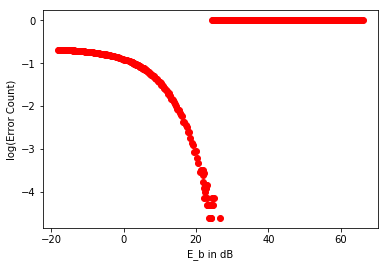

In [68]:
d = 2
E_b = []
errors = []

for test_P in P:
    for test_std in std:
        err = 0
        
        for i in range(int(runs/msg_len)):
            errs = 0
            [msg, code] = standardOutput(test_P, msg_len)
            recMsg = standardReceiver(code, test_std)
            errs += sum(1 for a, b in zip("".join(str(int(e)) for e in msg), "".join(str(int(v)) for v in recMsg)) if a != b)
            if(errs > 0):
                err += 1
        
        if(np.random.uniform() > 0.999):
            print(err, test_P)
        E_b.append(test_P/(d*test_std**2))
        errors.append(msg_len*err/(runs*d**2))
        
        if E_b[-1] == 0:
            E_b[-1] = 10**0
        if errors[-1] == 0:
            errors[-1] = 10**0

plt.plot(np.array(20*np.log10(E_b)), np.array(np.log10(errors)), 'ro')
plt.xlabel("E_b in dB")
plt.ylabel("log(Error Count)")
plt.show()